# Models

## 1. Import Libraries

In [1]:
# Global
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import requests

# M1
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

# M2
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# Model comparison
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score

## 2. Load Data

In [ ]:
api_url = "https://api.github.com/repos/HardyUnine/ML_Project/contents/data"

csv_files = requests.get(api_url).json()

csv_urls = [f["download_url"] for f in csv_files if f["name"].endswith(".csv")]

## 3. Preprocessing

In [ ]:
def add_features(df):
    columns_to_lag = ['SIR', 'RSI', 'BF', 'ADV', 'PRICE_PER_SHARE']
    lags = [1, 2]

    for col in columns_to_lag:
        for lag in lags:
            df[f'{col}_lag{lag}'] = df[col].shift(lag)

    window = 3

    for col in columns_to_lag:
        df[f'{col}_3day_mean'] = df[col].rolling(window=window).mean()
        df[f'{col}_3day_std'] = df[col].rolling(window=window).std()

    df["SS_future3"] = (df.groupby("COMPANY_NAME")["SS"].transform(lambda x: x.shift(-3)))

    df["SS_future3"] = (df["SS_future3"] > 0).astype(int)
    
    return df

In [ ]:
# Process all CSVs from GitHub
all_dfs = []
for url in csv_urls:
    df = pd.read_csv(url)
    df = add_features(df)
    all_dfs.append(df)

# Combine into one DataFrame
combined_df = pd.concat(all_dfs, ignore_index=True)
combined_df = combined_df.sort_values(by=['COMPANY_NAME', 'DAY']).reset_index(drop=True)

combined_df.shape
combined_df.drop(["COMPANY_NAME", "TICKER", "DAY"], axis=1, inplace=True)
combined_df.shape

(775, 30)

## 4. Train/Test split 

In [ ]:
# Split data in dependent and independant variables
X = combined_df.drop(columns=["SS_future3"])

y = combined_df["SS_future3"].copy()
print(y.head())
#y.shape

0    0
1    0
2    0
3    0
4    0
Name: SS_future3, dtype: int64


In [ ]:
print(sum(y)/len(y)) # to check how many positives we have
# sum of how many squeezes, divided by total 
# data will probably be inbalances (ex. 30% squeezes) so need to make sure that there is 30% in both the train and test data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # stratify = yes, we want same percetages everywjere
X_train = np.nan_to_num(X_train, nan=0.0)
X_test = np.nan_to_num(X_test, nan=0.0)


print(sum(y_train)/len(y_train))
print(sum(y_test)/len(y_test)) # check that they have the same percentages of squeezes

0.10838709677419354
0.10806451612903226
0.10967741935483871


## 5. M1: Gradient-Boosted decisions Trees with LightGBM

[LightGBM] [Info] Number of positive: 67, number of negative: 553
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4387
[LightGBM] [Info] Number of data points in the train set: 620, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.108065 -> initscore=-2.110665
[LightGBM] [Info] Start training from score -2.110665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

/Users/angelikiandreadi/Library/CloudStorage/OneDrive-unine.ch/Unine/Semestre_5/Intro_to_ML/Assignments/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


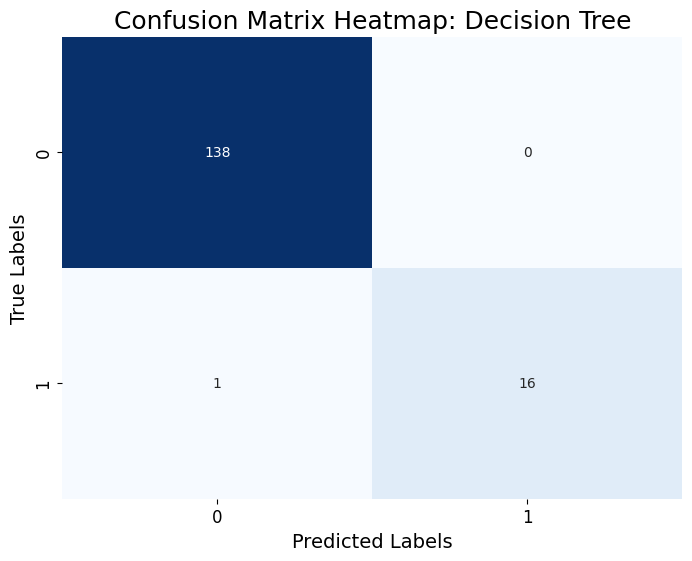

In [ ]:
train_data = lgb.Dataset(X_train, label=y_train)
valid_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

clf_lgb = LGBMClassifier(num_leaves=31,learning_rate=0.05, n_estimators=200)
clf_lgb.fit(X_train, y_train)

y_pred_prob = clf_lgb.predict(X_test)
dt_pred = (y_pred_prob > 0.5).astype(int)

acc = accuracy_score(y_test, dt_pred)
cm = confusion_matrix(y_test, dt_pred) 

print("Accuracy:", acc)

cm_df = pd.DataFrame(
    cm,
    index=['Actual Negative', 'Actual Positive'],
    columns=['Predicted Negative', 'Predicted Positive']
)

print(cm_df)

conf_matrix = confusion_matrix(y_test, dt_pred)
plt.figure(figsize = (8,6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)

plt.title("Confusion Matrix Heatmap: Decision Tree", fontsize=18)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## 6. M2: Random Forest

In [ ]:
scaler = StandardScaler()
X_train= scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#X_train.shape
X_test.shape

In [ ]:
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train)
rf_pred = classifier.predict(X_test)

Accuracy: 98.06%


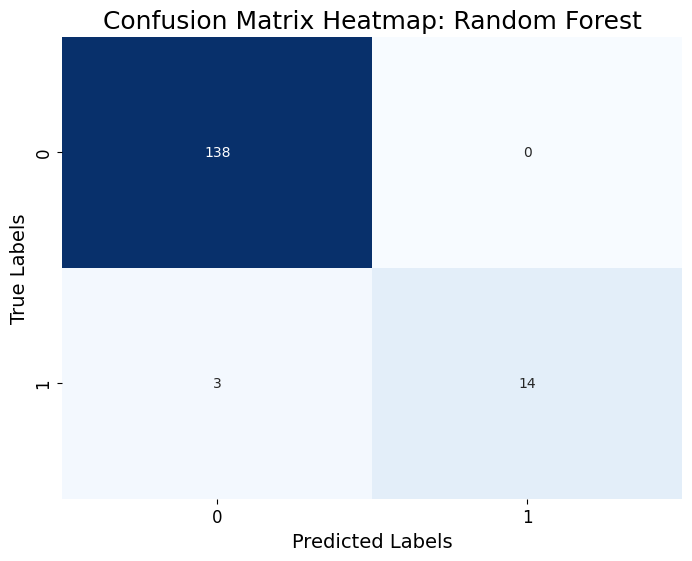

In [ ]:
accuracy = accuracy_score(y_test, rf_pred)
print(f'Accuracy: {accuracy*100:.2f}%')

conf_matrix = confusion_matrix(y_test, rf_pred)
plt.figure(figsize = (8,6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', cbar=False)

plt.title("Confusion Matrix Heatmap: Random Forest", fontsize=18)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## 7. Model comparison

In [ ]:
acc_rf = accuracy_score(y_test, rf_pred)
acc_dt = accuracy_score(y_test, dt_pred)

In [ ]:
prec_rf = precision_score(y_test, rf_pred)
rec_rf  = recall_score(y_test, rf_pred)
f1_rf   = f1_score(y_test, rf_pred)

prec_dt = precision_score(y_test, dt_pred)
rec_dt  = recall_score(y_test, dt_pred)
f1_dt   = f1_score(y_test, dt_pred)


In [ ]:
cv_rf = cross_val_score(clf_lgb, X, y, cv=5, scoring='f1')
cv_dt = cross_val_score(classifier, X, y, cv=5, scoring='f1')

[LightGBM] [Info] Number of positive: 68, number of negative: 552
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4418
[LightGBM] [Info] Number of data points in the train set: 620, number of used features: 29
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.109677 -> initscore=-2.094040
[LightGBM] [Info] Start training from score -2.094040
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

In [ ]:
results = {
    "Model": ["Random Forest", "Decision Tree"],
    "Accuracy": [acc_rf, acc_dt],
    "Precision": [prec_rf, prec_dt],
    "Recall": [rec_rf, rec_dt],
    "F1-Score": [f1_rf, f1_dt],
}

df_results = pd.DataFrame(results)
print(df_results)


           Model  Accuracy  Precision    Recall  F1-Score
0  Random Forest  0.980645        1.0  0.823529  0.903226
1  Decision Tree  0.993548        1.0  0.941176  0.969697


## 8. M2 Test on real-world data

In [ ]:
url = "https://raw.githubusercontent.com/HardyUnine/ML_Project/main/real_data_code/GME_api_ss.csv"
real_df = pd.read_csv(url)

print(real_df.head())

InvalidURL: URL can't contain control characters. '/HardyUnine/ML_Project/main/real data code/GME_api_ss.csv' (found at least ' ')

In [ ]:
real_df = add_features(real_df)
real_df.drop(["COMPANY_NAME", "TICKER", "DAY"], axis=1, inplace=True)

In [ ]:
x_real = real_df.drop(columns=["SS_future3"])
x_real.fillna(0, inplace=True)
print(x_real.head())

In [ ]:
y_real = real_df["SS_future3"].copy()
y_real.head()

0    0
1    0
2    0
3    0
4    0
Name: SS_future3, dtype: int64

In [ ]:
y_pred_real = clf_lgb.predict(x_real)

In [ ]:
accuracy_real = accuracy_score(y_real, y_pred_real)
precision_real = precision_score(y_real, y_pred_real)
recall_real = recall_score(y_real, y_pred_real)
f1_real = f1_score(y_real, y_pred_real)

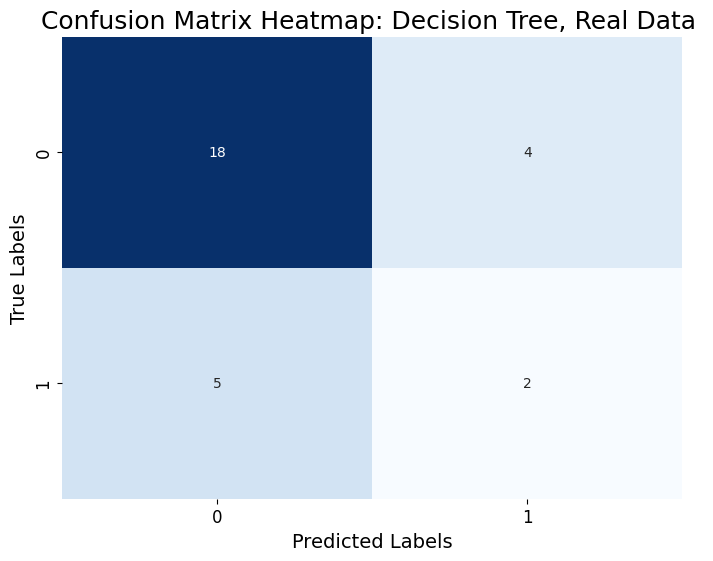

In [ ]:
conf_matrix_real = confusion_matrix(y_real, y_pred_real)
plt.figure(figsize = (8,6))
sns.heatmap(conf_matrix_real, annot=True, fmt='g', cmap='Blues', cbar=False)

plt.title("Confusion Matrix Heatmap: Decision Tree, Real Data ", fontsize=18)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [ ]:
real_results = {
    "Model": ["Decison Tree"],
    "Accuracy": [accuracy_real],
    "Precision": [precision_real],
    "Recall": [recall_real],
    "F1-Score": [f1_real],
}

dt_real_results = pd.DataFrame(real_results)
print(dt_real_results)

          Model  Accuracy  Precision    Recall  F1-Score
0  Decison Tree  0.689655   0.333333  0.285714  0.307692


In [ ]:
y_pred_real_rf = classifier.predict(x_real)

/Users/angelikiandreadi/Library/CloudStorage/OneDrive-unine.ch/Unine/Semestre_5/Intro_to_ML/Assignments/.venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [ ]:
accuracy_real = accuracy_score(y_real, y_pred_real_rf)
precision_real = precision_score(y_real, y_pred_real_rf)
recall_real = recall_score(y_real, y_pred_real_rf)
f1_real = f1_score(y_real, y_pred_real_rf)

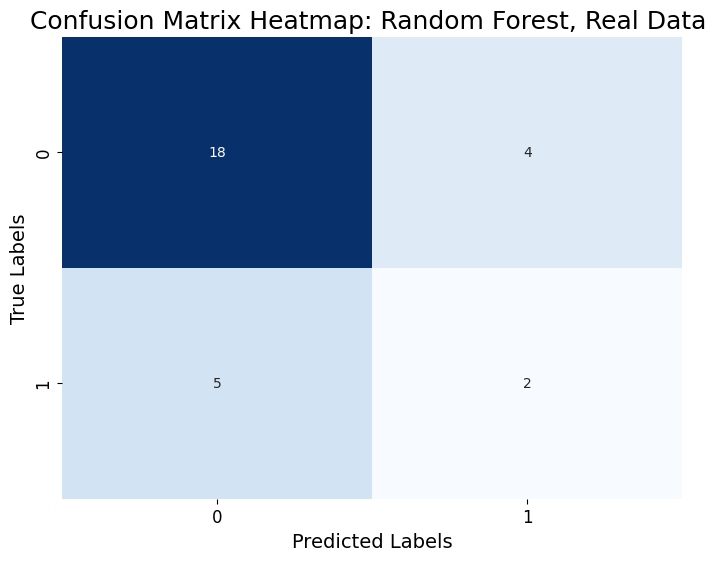

In [ ]:
conf_matrix_real = confusion_matrix(y_real, y_pred_real)
plt.figure(figsize = (8,6))
sns.heatmap(conf_matrix_real, annot=True, fmt='g', cmap='Blues', cbar=False)

plt.title("Confusion Matrix Heatmap: Random Forest, Real Data ", fontsize=18)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [ ]:
real_results = {
    "Model": ["Decison Tree"],
    "Accuracy": [accuracy_real],
    "Precision": [precision_real],
    "Recall": [recall_real],
    "F1-Score": [f1_real],
}

dt_real_results = pd.DataFrame(real_results)
print(dt_real_results)

          Model  Accuracy  Precision  Recall  F1-Score
0  Decison Tree  0.482759   0.318182     1.0  0.482759
